## RAG System Performance Analysis — ServiceTitan Internship

### The Difference Between Task 1 and Task 2

| Task     | Focus                                | Your Role          | Type of Thinking         |
|----------|---------------------------------------|--------------------|--------------------------|
| **Task 1** | Analyze the logs to find problems     | Diagnostician       | System-level debugging   |
| **Task 2** | Choose between two upgrades           | Product engineer    | Cost-benefit analysis    |

### Dataset Overview

**Total Entries:** 81

#### Columns:

| Column Name           | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| `query_id`            | Unique ID for each user query                                               |
| `user_query`          | The natural language question asked by the user                             |
| `retrieved_chunks`    | List of retrieved documents (includes `source` info: `wiki`, `confluence`, `pdf`) |
| `final_answer`        | The generated response to the query                                         |
| `response_latency_ms` | Time taken to generate the full response (in milliseconds)                  |
| `user_feedback`       | User feedback on the answer — either `thumb_up` or `thumb_down`             |


In [ ]:
import pandas as pd
import json
from collections import defaultdict
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/lilykostanyan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
# Load the JSON file into a DataFrame
with open("logs.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

## Task 1: Root Cause Analysis

### Count Feedback Results by Source

In [8]:
# Initialize counters
source_feedback_counts = defaultdict(lambda: {'thumb_up': 0, 'thumb_down': 0})

# Loop through logs and tally feedback by source
for _, row in df.iterrows():
    feedback = row['user_feedback']
    chunks = row['retrieved_chunks']
    
    for chunk in chunks:
        source = chunk['source']
        source_feedback_counts[source][feedback] += 1

# Convert to DataFrame
feedback_df = pd.DataFrame.from_dict(source_feedback_counts, orient='index')
feedback_df['total'] = feedback_df['thumb_up'] + feedback_df['thumb_down']
feedback_df = feedback_df.sort_values(by='total', ascending=False)

# Display result
print(feedback_df)

                             thumb_up  thumb_down  total
Engineering Wiki                  108          19    127
Confluence                         88          20    108
Archived Design Docs (PDFs)        64          25     89


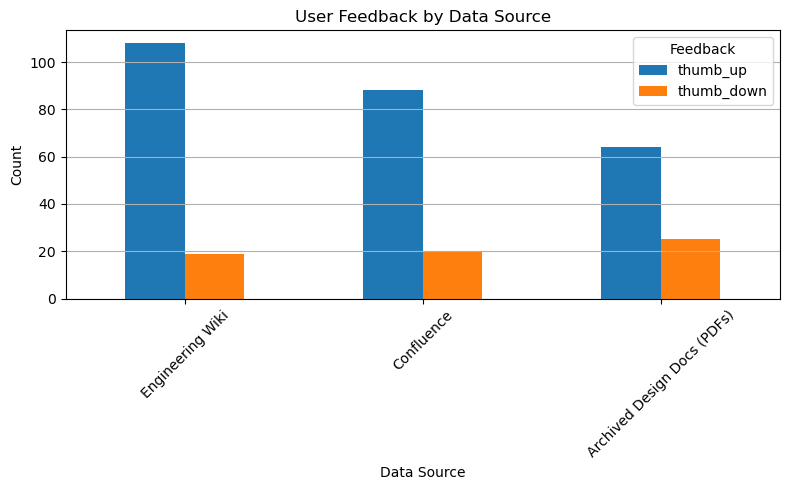

In [24]:
import matplotlib.pyplot as plt

# Plot thumbs-up and thumbs-down by source
ax = feedback_df[['thumb_up', 'thumb_down']].plot(
    kind='bar',
    stacked=False,
    figsize=(8, 5),
    title='User Feedback by Data Source',
    ylabel='Count',
    xlabel='Data Source',
    rot=45
)

plt.tight_layout()
plt.grid(axis='y')
plt.legend(title='Feedback')


#### PDFs have the worst thumbs-down rate

- **28%** of retrieved PDF chunks received a thumbs-down (25 / 89)
- Compare that to:
  - **Confluence:** 18.5%
  - **Wiki:** 15%

This strongly supports the hypothesis that **PDFs contain outdated or irrelevant information** and negatively affect the chatbot’s accuracy.

---

#### Engineering Wiki is the most used and best-performing

- **108 out of 127** chunks from Wiki got a thumbs-up — an **85% approval rate**
- Suggests that **live, continuously updated sources are more reliable** for RAG (Retrieval-Augmented Generation)

---

#### Confluence is in the middle

- Still a **solid performance**, but with slightly more thumbs-downs than Wiki
- Since it updates **daily**, some **latency in updates may cause minor issues**

### Latency Analysis

In [16]:
# Count how many responses exceed the 3500ms SLA
over_sla_count = (df['response_latency_ms'] > 3500).sum()
total_count = len(df)
percent_over_sla = (over_sla_count / total_count) * 100

# Get examples of high-latency entries
high_latency_examples = df[df['response_latency_ms'] > 3500][['query_id', 'user_query', 'response_latency_ms']].head()

(over_sla_count, total_count, percent_over_sla, high_latency_examples)

(23,
 81,
 28.39506172839506,
     query_id                                         user_query  \
 3   f8a2b5e4  Give me a complete summary of all key architec...   
 7   9i0j1k2l  Summarize the key findings from the 2021 user ...   
 11  5y6z7a8b  What are the performance benchmarks for the ne...   
 14  1l0m9n8o  What is the company's policy on open source so...   
 18  5b4c3d2e  What is the process for deprecating an API end...   
 
     response_latency_ms  
 3                  4850  
 7                  5100  
 11                 4150  
 14                 3900  
 18                 3800  )

#### Issue

- The system **violates its 99th percentile latency SLA of 3,500ms**, meaning 99% of responses must be faster than 3.5 seconds.

---

#### Findings

- **23 out of 81 queries (28.4%)** exceeded this latency limit.
- Some responses took **over 5 seconds** to generate.

---

#### Pattern

- The **slowest queries** often asked for:
  - **Summaries**
  - **Policy details**
- These queries likely triggered longer responses due to:
  - **High token volume** passed to the generator
  - **Verbose inputs** from retrieved documents
  - **Multi-chunk retrieval** (even at k=4, this can be 1,600+ tokens)

---

#### Root Cause

- The **Generation component**, powered by **LLaMA 3 (70B)**, is the main source of latency.
- Document **retrieval is fast and stable**, but **LLaMA 3 introduces delays** when handling:
  - Long or complex inputs
  - Multi-document context
  - Lengthy or detailed outputs

---

#### Why This Happens

- **Large language models like LLaMA 3 are computationally intensive**
- As token count increases (in both input and output), latency increases rapidly

---

#### Implication

To improve latency, we must consider:

- Reducing **input chunk size**
- Lowering the **number of chunks retrieved (k)**
- Simplifying or optimizing the **prompt structure**
- Possibly using a **smaller/faster model** for hig

### Highlight Examples with Outdated Info from PDFs

In [17]:
# Step 3: Find bad answers associated with PDF chunks

# Filter rows with thumbs down
thumbs_down_df = df[df['user_feedback'] == 'thumb_down']

# Now check if any of the retrieved_chunks in those rows have source == 'Archived Design Docs (PDFs)'
pdf_bad_rows = []

for _, row in thumbs_down_df.iterrows():
    for chunk in row['retrieved_chunks']:
        if chunk['source'] == 'Archived Design Docs (PDFs)':
            pdf_bad_rows.append({
                'query_id': row['query_id'],
                'user_query': row['user_query'],
                'final_answer': row['final_answer'],
                'response_latency_ms': row['response_latency_ms']
            })
            break  # only need to record once per query

# Convert to DataFrame
pdf_bad_df = pd.DataFrame(pdf_bad_rows)
pdf_bad_df.head(5)

,query_id,user_query,final_answer,response_latency_ms
0,a7b3c9d1,What is our company's policy on using GPT-4 fo...,According to the 'AI Usage Guidelines' documen...,3450
1,c9d1b3a7,What is the correct function signature for the...,The `getUserProfile` endpoint was discussed du...,3100
2,1a2b3c4d,What was the Q1 2023 revenue for the EU region?,The Q1 2023 earnings call notes mention strong...,2900
3,7q8r9s0t,What is the latest update on the office reopen...,"According to the HR policy document, the compa...",3300
4,5y6z7a8b,What are the performance benchmarks for the ne...,The performance report for the v2 recommendati...,4150



**PDFs are linked to inaccurate or outdated responses.**  
Queries retrieving chunks from *Archived Design Docs (PDFs)* often failed, especially when:

- The question required **current information**
- The PDFs cited were **static or obsolete**

---

#### Examples of PDF-Based Failures

- **“What is our company's policy on using GPT-4?”**  
  → Cited a **2022 policy PDF**, likely outdated.

- **“What was Q1 2023 revenue?”**  
  → Retrieved data from **archived financial documents**, not recent updates.

- **“What are the latest performance benchmarks?”**  
  → Referenced **v2 data**, while the system now runs on **v4**.

---

#### Pattern

- All examples involved **time-sensitive queries** answered using **static PDFs**.
- Retrieval favored PDFs due to **token density**, not **content freshness**.

---

#### Root Cause

- The **Retrieval component** is **biased toward high-token-density content**, especially PDFs.
- It fails to rank more **timely and relevant sources** (like Wiki or Confluence) higher.
- The **Generator** then relies on these **misleading contexts**, degrading response quality.

---

#### Implication

To **improve accuracy** and **user satisfaction**, the system should:

- **Down-rank static PDFs** unless the query clearly requests archived information
- **Prioritize live, updated sources** such as:
  - **Engineering Wiki**
  - **Confluence**

---

#### Recommendation

Update the **retrieval scoring logic** to:

- Favor **recency** and **source freshness**
- Penalize **static, unchanging content** (PDFs) for real-time queries

## Task 2: Quantitative Trade-Off Analysis

---

To improve the relevance of chatbot answers, the engineering team proposed two mutually exclusive upgrades. The goal of this analysis is to evaluate both options in terms of cost, latency, and quality impact — and to make a final recommendation based on our system’s current limitations.

---

### Option A: Add a Cohere Re-ranker

- **Latency Impact:** +600ms per query
- **Monthly Cost:** $1.00 per 1,000 queries → $100/month for 100,000 queries
- **Benefit:** Improves accuracy by re-ranking top-10 retrieved chunks and selecting the best 4 to pass to the generator
- **Token Load:** No change to token count (LLaMA 3 cost remains stable)

---

### Option B: Increase Context Size (k=4 → k=10)

- **Retrieval Latency:** +250ms per query
- **Generation Impact:**
  - 6 extra chunks per query × 400 tokens = **+2,400 tokens/query**
  - At 100,000 queries/month → **240,000,000 extra tokens**
- **Monthly Generation Cost Increase** -
To estimate the additional monthly cost from Option B, we use the following calculation:
$$
\text{Extra tokens per query} = 6 \times 400 = 2400 \text{ tokens}
$$

$$
\text{Total monthly extra tokens} = 2400 \times 100{,}000 = 240{,}000{,}000 \text{ tokens}
$$

$$
\text{Monthly cost increase} = \frac{240{,}000{,}000}{1{,}000{,}000} \times 3 = \boxed{\$720}
$$

- **Total Latency Impact:** 250ms (retrieval) + slower generation due to more input tokens

---

### Comparison Table

| Metric                     | Option A: Re-ranker         | Option B: k=10 Retrieval          |
|---------------------------|-----------------------------|----------------------------------|
| **Added Latency**         | +600ms                      | +250ms (retrieval only) + gen delay |
| **Monthly Cost**          | $100                        | $720                             |
| **Token Load**            | No change                   | +240M tokens/month               |
| **Generation Stress**     | Low                         | High                             |
| **Affected Component**    | Retrieval                   | Retrieval + Generation           |
| **Relevance Gain**        | Higher precision (top-4)    | Higher recall (more context)     |
| **SLA Violation Risk**    | Medium                      | High (generation bottleneck)     |

(Precision = better top-4 selection, Recall = retrieving more possibly relevant info)

---

### Why Option B Is Riskier

- The system’s **main performance bottleneck is Generation (LLaMA 3)**.
- 28.4% of queries already exceed the 3,500ms SLA.
- Adding 2,400 tokens per query will slow down LLaMA 3 even more.
- While Option B provides more context, it also **adds significant cost ($720/month)** and could worsen latency issues.
- Relevance gains are uncertain, especially if extra context contains redundant or irrelevant chunks.

---

### Why Option A Is Better

- It **improves chunk quality** before passing them to the generator — no need to overload it with more input.
- Keeps token size and cost stable.
- Cost-effective: **$100/month vs $720/month**
- Re-ranking allows smarter selection of chunks, which can lead to **better answers without more latency from LLaMA 3**.
- Even with a 600ms increase, the overall system may perform more consistently and predictably.

Option A’s latency impact is fixed and predictable. Option B’s impact compounds with input size, making performance harder to control.

---

### Final Recommendation

**I recommend Option A: Add a Cohere Re-ranker.**

It is the more scalable, cost-effective solution that aligns with current system limitations. By improving retrieval precision without increasing input size, Option A avoids burdening the already stressed LLaMA 3 generation step — and helps improve answer quality while keeping costs and latency within acceptable bounds. 

This choice not only addresses current system weaknesses but also provides a safer foundation for future improvements.
